In [ ]:
# download data set
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar xvzf food-101.tar.gz

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/695879.jpg
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
!mkdir -p subset/train
!ls food-101/images | xargs -I {}  cp -r food-101/images/{} subset/train

In [ ]:
!nvidia-smi

Wed Dec  6 21:45:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torch-lr-finder efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=6d9e2a536d553f60c49b65e41ad0968fe4e285243bba9e4621a6baa088a84778
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from efficientnet_pytorch import EfficientNet

In [ ]:
train_transforms = torchvision.transforms.Compose([
        torchvision.transforms.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1),
        torchvision.transforms.RandomAffine(15),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(15),
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
valid_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder('subset/train/',transform=train_transforms)
valid_dataset = torchvision.datasets.ImageFolder('food-101/images/',transform=valid_transforms)

In [ ]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size,shuffle=True,num_workers=2,pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size,shuffle=False,num_workers=2,pin_memory=True)

In [ ]:
def visualize_images(dataloader):
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    figure, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 14))
    classes = list(dataloader.dataset.class_to_idx.keys())
    img_no = 0
    for images,labels in dataloader:
        for i in range(3):
            for j in range(3):
                img = np.array(images[img_no]).transpose(1,2,0)
                lbl = labels[img_no]

                ax[i,j].imshow((img*std) + mean)
                ax[i,j].set_title(classes[lbl])
                ax[i,j].set_axis_off()
                img_no+=1
        break

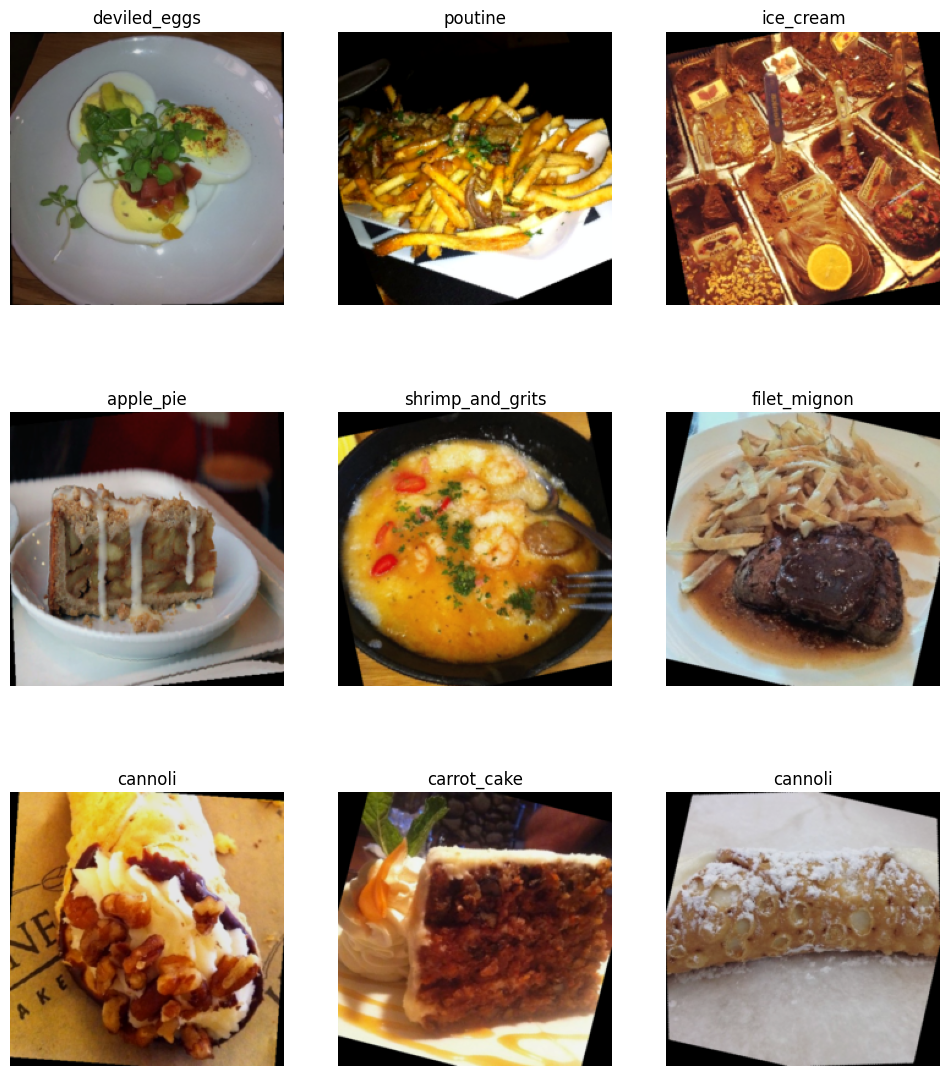

In [ ]:
visualize_images(train_loader)

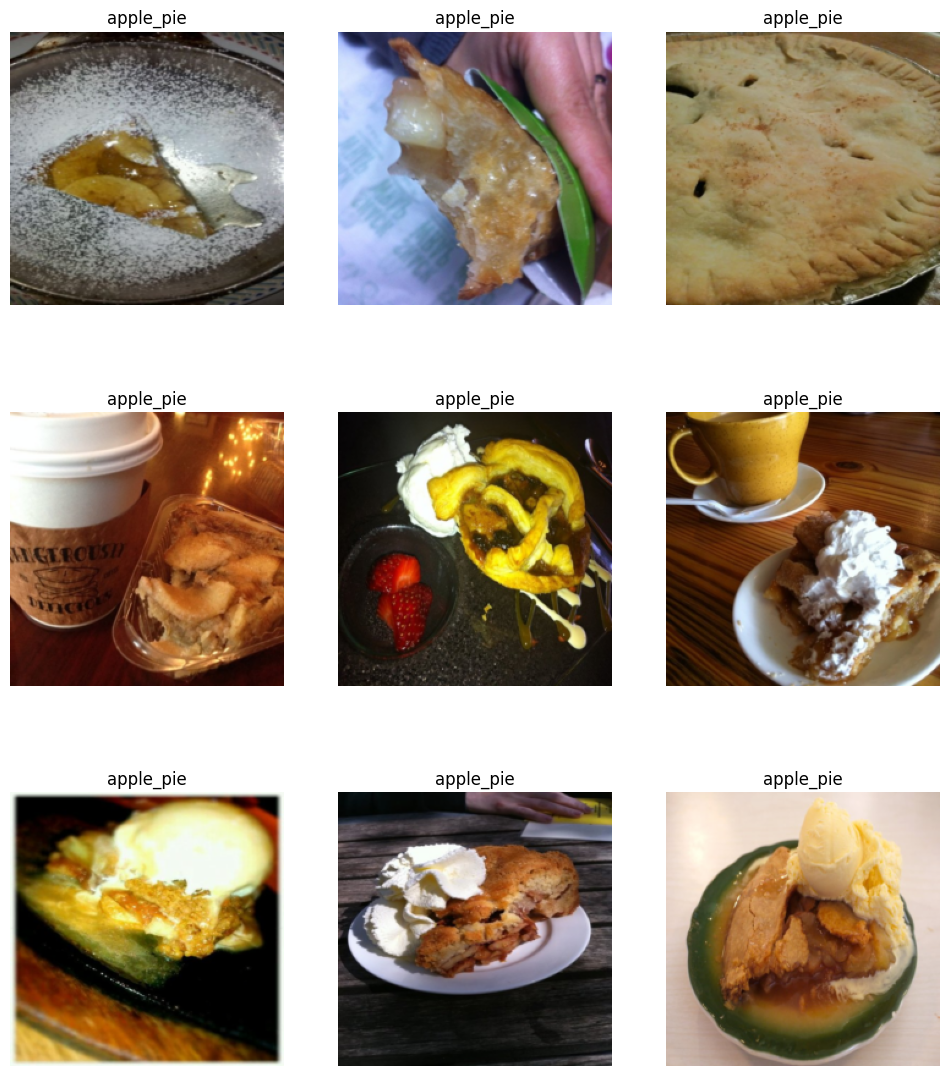

In [ ]:
visualize_images(valid_loader)

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b5')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:06<00:00, 18.1MB/s]


Loaded pretrained weights for efficientnet-b5


In [ ]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [ ]:
# Freeze first few layers. try different values
for i,param in enumerate(model.parameters()):
    if i<=300:
        param.requires_grad=False

In [ ]:
model._dropout = torch.nn.Dropout(0.5)
model._fc = torch.nn.Linear(2048,101)

  0%|          | 0/25 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E-04


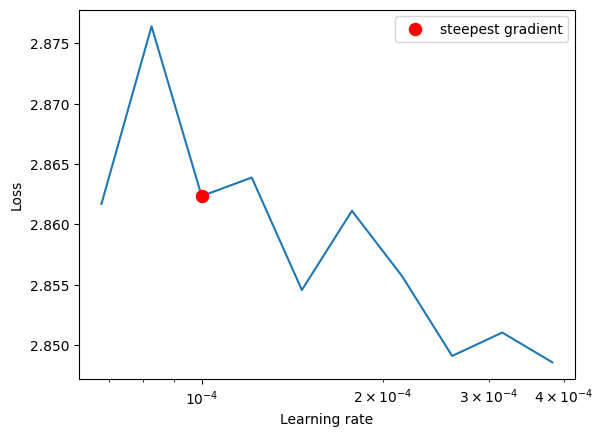

In [ ]:
from torch_lr_finder import LRFinder
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=0.001, num_iter=25)
lr_finder.plot()
lr_finder.reset()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir runs

In [ ]:
cuda = True
epochs = 25
model_name = 'drive/MyDrive/can-i-cook-it/effnetB5.pt'
optimizer = torch.optim.Adam(model.parameters(),lr=4e-4,weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.1,patience=2,verbose=True)

writer = SummaryWriter() # For Tensorboard
early_stop_count=0
ES_patience=5
best = 0.0
if cuda:
    model.cuda()

for epoch in range(epochs):

    # Training
    model.train()
    correct = 0
    train_loss = 0.0
    tbar = tqdm(train_loader, desc = 'Training', position=0, leave=True)
    for i,(inp,lbl) in enumerate(tbar):
        optimizer.zero_grad()
        if cuda:
            inp,lbl = inp.cuda(),lbl.cuda()
        out = model(inp)
        loss = criterion(out,lbl)
        train_loss += loss
        out = out.argmax(dim=1)
        correct += (out == lbl).sum().item()
        loss.backward()
        optimizer.step()
        tbar.set_description(f"Epoch: {epoch+1}, loss: {loss.item():.5f}, acc: {100.0*correct/((i+1)*train_loader.batch_size):.4f}%")
    train_acc = 100.0*correct/len(train_loader.dataset)
    train_loss /= (len(train_loader.dataset)/batch_size)

    #Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        val_loss = 0.0
        vbar = tqdm(valid_loader, desc = 'Validation', position=0, leave=True)
        for i,(inp,lbl) in enumerate(vbar):
            if cuda:
                inp,lbl = inp.cuda(),lbl.cuda()
            out = model(inp)
            val_loss += criterion(out,lbl)
            out = out.argmax(dim=1)
            correct += (out == lbl).sum().item()
        val_acc = 100.0*correct/len(valid_loader.dataset)
        val_loss /= (len(valid_loader.dataset)/batch_size)
    print(f'\nEpoch: {epoch+1}/{epochs}')
    print(f'Train loss: {train_loss}, Train Accuracy: {train_acc}')
    print(f'Validation loss: {val_loss}, Validation Accuracy: {val_acc}\n')

    scheduler.step(val_loss)

    # write to tensorboard
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)

    if val_acc>best:
        best=val_acc
        torch.save(model,model_name)
        early_stop_count=0
        print('Accuracy Improved, model saved.\n')
    else:
        early_stop_count+=1

    if early_stop_count==ES_patience:
        print('Early Stopping Initiated...')
        print(f'Best Accuracy achieved: {best:.2f}% at epoch:{epoch+1-ES_patience}')
        print(f'Model saved as {model_name}')
        break
    writer.flush()

Validation: 100%|██████████| 790/790 [11:13<00:00,  1.17it/s]



Epoch: 1/25
Train loss: 1.5496972799301147, Train Accuracy: 60.81584158415841
Validation loss: 1.1364942789077759, Validation Accuracy: 72.28019801980199

Accuracy Improved, model saved.



Validation: 100%|██████████| 790/790 [11:13<00:00,  1.17it/s]



Epoch: 2/25
Train loss: 1.1207057237625122, Train Accuracy: 70.66039603960397
Validation loss: 1.041819453239441, Validation Accuracy: 75.35643564356435

Accuracy Improved, model saved.



Validation: 100%|██████████| 790/790 [11:13<00:00,  1.17it/s]



Epoch: 3/25
Train loss: 1.0289186239242554, Train Accuracy: 72.92277227722772
Validation loss: 0.9654186367988586, Validation Accuracy: 76.87029702970297

Accuracy Improved, model saved.



Validation: 100%|██████████| 790/790 [11:13<00:00,  1.17it/s]



Epoch: 4/25
Train loss: 0.9814828634262085, Train Accuracy: 74.01881188118811
Validation loss: 0.898261547088623, Validation Accuracy: 78.67623762376238

Accuracy Improved, model saved.



Validation: 100%|██████████| 790/790 [11:12<00:00,  1.17it/s]



Epoch: 5/25
Train loss: 0.9523099660873413, Train Accuracy: 75.0
Validation loss: 0.8184297680854797, Validation Accuracy: 79.66930693069307

Accuracy Improved, model saved.



Validation: 100%|██████████| 790/790 [11:12<00:00,  1.17it/s]



Epoch: 6/25
Train loss: 0.9388042688369751, Train Accuracy: 75.28514851485149
Validation loss: 0.7725794315338135, Validation Accuracy: 80.07524752475247

Accuracy Improved, model saved.



Validation: 100%|██████████| 790/790 [11:12<00:00,  1.17it/s]



Epoch: 7/25
Train loss: 0.931016743183136, Train Accuracy: 75.62673267326733
Validation loss: 0.7857384085655212, Validation Accuracy: 80.03465346534654



Validation: 100%|██████████| 790/790 [11:12<00:00,  1.18it/s]



Epoch: 8/25
Train loss: 0.9297381639480591, Train Accuracy: 75.68316831683168
Validation loss: 0.7533805966377258, Validation Accuracy: 80.91782178217822

Accuracy Improved, model saved.



Validation: 100%|██████████| 790/790 [11:11<00:00,  1.18it/s]



Epoch: 9/25
Train loss: 0.9311181902885437, Train Accuracy: 75.78217821782178
Validation loss: 0.7741224765777588, Validation Accuracy: 80.32376237623762



Validation: 100%|██████████| 790/790 [11:10<00:00,  1.18it/s]



Epoch: 10/25
Train loss: 0.9291478991508484, Train Accuracy: 75.78910891089109
Validation loss: 0.7486326694488525, Validation Accuracy: 80.6920792079208



Validation: 100%|██████████| 790/790 [11:08<00:00,  1.18it/s]



Epoch: 11/25
Train loss: 0.9287932515144348, Train Accuracy: 75.77128712871287
Validation loss: 0.7413678169250488, Validation Accuracy: 80.88613861386139



Validation: 100%|██████████| 790/790 [11:06<00:00,  1.18it/s]



Epoch: 12/25
Train loss: 0.9259273409843445, Train Accuracy: 75.86039603960396
Validation loss: 0.7357705235481262, Validation Accuracy: 81.28118811881188

Accuracy Improved, model saved.



Validation: 100%|██████████| 790/790 [11:05<00:00,  1.19it/s]



Epoch: 13/25
Train loss: 0.9249840378761292, Train Accuracy: 75.87821782178217
Validation loss: 0.7508203983306885, Validation Accuracy: 81.32079207920792

Accuracy Improved, model saved.



Validation: 100%|██████████| 790/790 [11:04<00:00,  1.19it/s]



Epoch: 14/25
Train loss: 0.9252203702926636, Train Accuracy: 75.83564356435643
Validation loss: 0.7479324340820312, Validation Accuracy: 80.61980198019802



Validation: 100%|██████████| 790/790 [11:03<00:00,  1.19it/s]



Epoch: 15/25
Train loss: 0.9236542582511902, Train Accuracy: 75.85841584158416
Validation loss: 0.7085875868797302, Validation Accuracy: 81.35049504950496

Accuracy Improved, model saved.



Validation: 100%|██████████| 790/790 [11:03<00:00,  1.19it/s]



Epoch: 16/25
Train loss: 0.91936194896698, Train Accuracy: 75.93861386138614
Validation loss: 0.7483696937561035, Validation Accuracy: 80.65544554455445



Validation: 100%|██████████| 790/790 [11:03<00:00,  1.19it/s]



Epoch: 17/25
Train loss: 0.9073434472084045, Train Accuracy: 76.2960396039604
Validation loss: 0.7170756459236145, Validation Accuracy: 81.11683168316831



Validation: 100%|██████████| 790/790 [11:02<00:00,  1.19it/s]



Epoch: 18/25
Train loss: 0.9089769124984741, Train Accuracy: 76.18514851485149
Validation loss: 0.7167695164680481, Validation Accuracy: 81.43168316831684

Epoch 00018: reducing learning rate of group 0 to 4.0000e-05.
Accuracy Improved, model saved.



Validation: 100%|██████████| 790/790 [11:02<00:00,  1.19it/s]



Epoch: 19/25
Train loss: 0.7364480495452881, Train Accuracy: 80.88514851485148
Validation loss: 0.5310584306716919, Validation Accuracy: 86.35148514851485

Accuracy Improved, model saved.



Validation: 100%|██████████| 790/790 [11:01<00:00,  1.19it/s]



Epoch: 20/25
Train loss: 0.6795937418937683, Train Accuracy: 82.37722772277228
Validation loss: 0.5010217428207397, Validation Accuracy: 87.04653465346534

Accuracy Improved, model saved.



Validation: 100%|██████████| 790/790 [11:02<00:00,  1.19it/s]



Epoch: 21/25
Train loss: 0.6571881175041199, Train Accuracy: 82.97227722772277
Validation loss: 0.48471230268478394, Validation Accuracy: 87.44653465346535

Accuracy Improved, model saved.



Validation: 100%|██████████| 790/790 [11:01<00:00,  1.19it/s]



Epoch: 22/25
Train loss: 0.6398746967315674, Train Accuracy: 83.36336633663366
Validation loss: 0.47347646951675415, Validation Accuracy: 87.78910891089109

Accuracy Improved, model saved.



Validation: 100%|██████████| 790/790 [11:02<00:00,  1.19it/s]



Epoch: 23/25
Train loss: 0.6328634023666382, Train Accuracy: 83.61881188118812
Validation loss: 0.4599401652812958, Validation Accuracy: 88.11683168316831

Accuracy Improved, model saved.



Validation: 100%|██████████| 790/790 [11:01<00:00,  1.19it/s]



Epoch: 24/25
Train loss: 0.6210062503814697, Train Accuracy: 83.97029702970298
Validation loss: 0.45575860142707825, Validation Accuracy: 88.4089108910891

Accuracy Improved, model saved.



Validation: 100%|██████████| 790/790 [11:01<00:00,  1.19it/s]



Epoch: 25/25
Train loss: 0.6143020987510681, Train Accuracy: 84.02673267326733
Validation loss: 0.4453999102115631, Validation Accuracy: 88.5

Accuracy Improved, model saved.

